In this notebook we build a convolutional neural network and train it to identify the track parameters (slope and intercept) in the toy track events generated by Steve's code.

Author: Dustin Anderson

In [103]:
# Standard imports
import sys

# Package imports
import numpy as np
np.random.seed(2341)

import matplotlib.pyplot as plt
%matplotlib inline

from keras import models, layers


# Local imports
sys.path.append("/home/duanders/AI-HEP.Trk/discrete_extraps")
from data import simulate_straight_track, generate_uniform_noise
from drawing import draw_event, draw_input_and_pred

In [72]:
# Training parameters
batch_size = 256
epoch_size = 256000
num_epochs = 10

# Data parameters
det_width = 50
det_depth = 50
det_shape = (det_width, det_depth)

## Model 1: convnet for single-track events with/without noise

Since our input data is very simple, we can generate it on the fly during training:

In [61]:
# Generator for training and validation data
def gen_tracks(batch_size=batch_size, det_shape=det_shape):
    """Arguments: 
         batch_size: number of events to yield for each call
       Yields: batches of training data for use with the keras fit_generator function
    """
    while True:
        # Entry and exit points are randomized
        bs = np.random.random_sample(size=batch_size)*det_width
        b2s = np.random.random_sample(size=batch_size)*det_width
        ms = (b2s-bs)/det_depth
        tracks = np.zeros((batch_size, 1, det_depth, det_width))
        targets = zip(bs, ms)
        for i, (b, m) in enumerate(targets):
            tracks[i][0] = simulate_straight_track(m, b, det_shape)
        targets = np.asarray(targets)
        yield tracks, targets

Let's draw 5 events on top of one another, just to test the event generator.  Note that training will make use of only single-track events for now.  

[[  4.14166409e+00  -2.15657869e-02]
 [  4.33185841e+01  -9.12703496e-02]
 [  2.37658732e+01   3.21562065e-01]
 [  4.48320323e+01  -3.55565539e-01]
 [  1.48923376e+01   2.59751276e-01]]


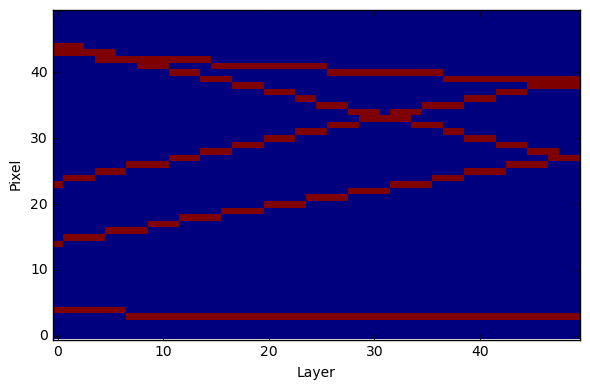

In [67]:
# Test the generator (layer 5 events on top of one another)
tracks, targets = gen_tracks().next()
big_event = np.clip(sum(tracks[:5,0]), 0, 1)
draw_event(big_event)
print targets[:5]

Now we build the model.  This ConvNet is just the first thing I happened to write down; the number of filters, number of convolutional and dense layers, etc, have no special significance.

In [70]:
# Model
def build_model_1():
    """Test model.  Consists of several convolutional layers followed by dense layers and an output layer"""
    input_layer = layers.Input(shape=(1, det_depth, det_width))
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(input_layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(8, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.MaxPooling2D(pool_size=(2,2))(layer)
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Convolution2D(16, 3, 3, border_mode='same')(layer)
    layer = layers.Activation('relu')(layer)
    layer = layers.Flatten()(layer)
    layer = layers.Dense(20)(layer)
    output_layer = layers.Dense(2)(layer)
    model = models.Model(input=input_layer, output=output_layer)
    model.compile(loss='mean_squared_error', optimizer='Adam')
    return model

In [74]:
# Train the model
model_1 = build_model_1()
train_generator = gen_tracks()
%time model_1.fit_generator(train_generator, epoch_size, num_epochs)

Epoch 1/10
256000/256000 [==============================] - 25s - loss: 6.2918 - acc: 0.9901    
Epoch 2/10
256000/256000 [==============================] - 25s - loss: 0.0229 - acc: 0.9968    
Epoch 3/10
256000/256000 [==============================] - 25s - loss: 0.0123 - acc: 0.9979    
Epoch 4/10
256000/256000 [==============================] - 25s - loss: 0.0158 - acc: 0.9980    
Epoch 5/10
256000/256000 [==============================] - 25s - loss: 0.0196 - acc: 0.9981    
Epoch 6/10
256000/256000 [==============================] - 25s - loss: 0.0222 - acc: 0.9981    
Epoch 7/10
256000/256000 [==============================] - 25s - loss: 0.0180 - acc: 0.9980    
Epoch 8/10
256000/256000 [==============================] - 25s - loss: 0.0179 - acc: 0.9982    
Epoch 9/10
256000/256000 [==============================] - 25s - loss: 0.0163 - acc: 0.9983    
Epoch 10/10
256000/256000 [==============================] - 25s - loss: 0.0165 - acc: 0.9983    
CPU times: user 2min 46s, sys

The keras "accuracy" values are not meaningful (see later).  

Let's check that the model can reconstruct the trajectory for noiseless events.  Should be a trivial task; the model just has to have figured out that slope = rise/run.

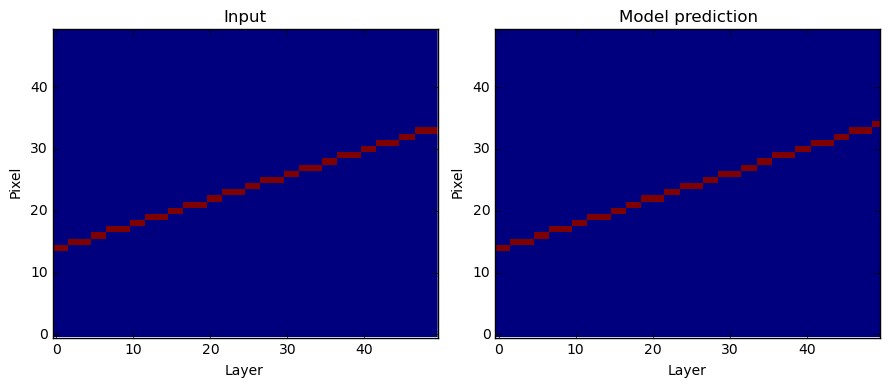

In [100]:
# Visualize prediction
test_event = gen_tracks().next()[0][0]
test_pred = model_1.predict(np.asarray([test_event]))[0]
pred_event = simulate_straight_track(test_pred[1], test_pred[0], det_shape)
draw_input_and_pred(test_event[0], pred_event)

Now let's inject noise into the events.

In [130]:
# Set noise level
noise_level = 0.3

In [131]:
# Generator for track events with noise injected
def gen_noisy_tracks(batch_size=batch_size, det_shape=det_shape, noise_level=noise_level):
    clean_gen = gen_tracks(batch_size, det_shape)
    for batch, targets in clean_gen: # note: loops forever
        for event in batch:
            event += np.asarray(generate_uniform_noise(1, det_shape, prob=noise_level, skip_layers=0))
        yield np.clip(batch, 0, 1), targets

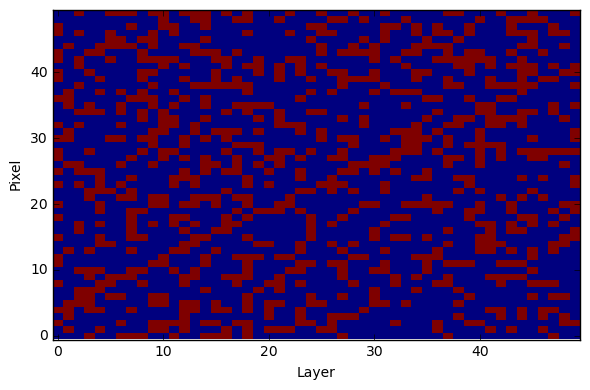

In [133]:
# Visualize noisy event
tracks, targets = gen_noisy_tracks(noise_level=noise_level).next()
draw_event(tracks[0,0])

In [134]:
# Train the model on noisy events
model_1 = build_model_1()
train_generator = gen_noisy_tracks(noise_level=noise_level)
%time history_noisy = model_1.fit_generator(train_generator, epoch_size, num_epochs)

Epoch 1/10
256000/256000 [==============================] - 26s - loss: 34.8673 - acc: 0.9807    
Epoch 2/10
256000/256000 [==============================] - 26s - loss: 8.0116 - acc: 0.9770    
Epoch 3/10
256000/256000 [==============================] - 26s - loss: 4.9445 - acc: 0.9776    
Epoch 4/10
256000/256000 [==============================] - 26s - loss: 3.3901 - acc: 0.9777    
Epoch 5/10
256000/256000 [==============================] - 26s - loss: 2.5235 - acc: 0.9785    
Epoch 6/10
256000/256000 [==============================] - 26s - loss: 2.0161 - acc: 0.9794    
Epoch 7/10
256000/256000 [==============================] - 26s - loss: 1.6546 - acc: 0.9801    
Epoch 8/10
256000/256000 [==============================] - 26s - loss: 1.4010 - acc: 0.9808    
Epoch 9/10
256000/256000 [==============================] - 26s - loss: 1.2009 - acc: 0.9815    
Epoch 10/10
256000/256000 [==============================] - 26s - loss: 1.0537 - acc: 0.9820    
CPU times: user 4min 42s, sy

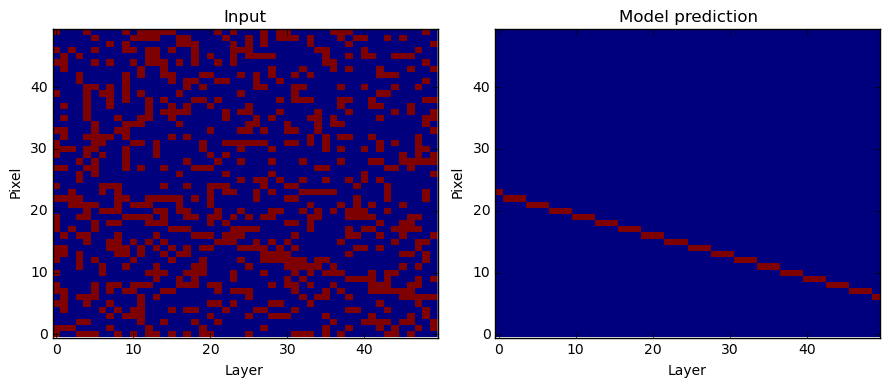

In [150]:
# Visualize prediction
test_event = gen_noisy_tracks(noise_level=noise_level).next()[0][0]
test_pred = model_1.predict(np.asarray([test_event]))[0]
pred_event = simulate_straight_track(test_pred[1], test_pred[0], det_shape)
draw_input_and_pred(test_event[0], pred_event)

It seems suspiciously good.  Let's do a sanity check with noise = 0.8.

In [152]:
# Train the model on noisy events
model_1_test = build_model_1()
%time history_noisy_test = model_1_test.fit_generator(gen_noisy_tracks(noise_level=0.8), epoch_size, num_epochs)

Epoch 1/10
256000/256000 [==============================] - 25s - loss: 100.0897 - acc: 0.9902    
Epoch 2/10
256000/256000 [==============================] - 26s - loss: 91.6518 - acc: 0.9902    
Epoch 3/10
256000/256000 [==============================] - 26s - loss: 90.9751 - acc: 0.9902    
Epoch 4/10
256000/256000 [==============================] - 26s - loss: 89.8250 - acc: 0.9902    
Epoch 5/10
256000/256000 [==============================] - 26s - loss: 89.1651 - acc: 0.9902    
Epoch 6/10
256000/256000 [==============================] - 26s - loss: 88.5453 - acc: 0.9903    
Epoch 7/10
256000/256000 [==============================] - 26s - loss: 87.9368 - acc: 0.9903    
Epoch 8/10
256000/256000 [==============================] - 26s - loss: 87.7819 - acc: 0.9902    
Epoch 9/10
256000/256000 [==============================] - 26s - loss: 87.2690 - acc: 0.9905    
Epoch 10/10
256000/256000 [==============================] - 26s - loss: 87.0369 - acc: 0.9902    
CPU times: user 4m

[ 42.42604952  -0.18141163]


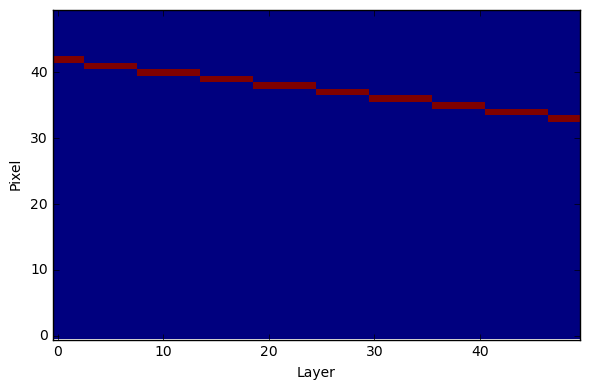

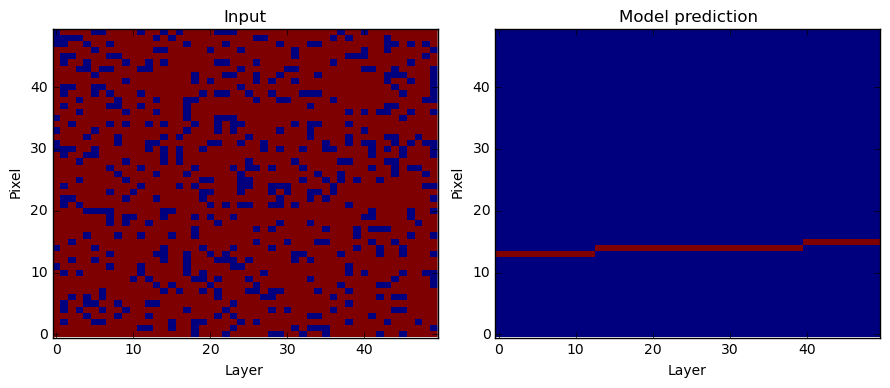

In [159]:
# Visualize prediction
test_input = gen_noisy_tracks(noise_level=0.8).next()
test_event = test_input[0][0]
test_target = test_input[1][0]
print test_target

test_pred = model_1.predict(np.asarray([test_event]))[0]
pred_event = simulate_straight_track(test_pred[1], test_pred[0], det_shape)
target_event = simulate_straight_track(test_target[1], test_target[0], det_shape)
draw_event(target_event)
draw_input_and_pred(test_event[0], pred_event)

Good.  When the noise is overwhelming, the model doesn't get it right.  So there does not seem to be any "cheating" going on.  I should remove the keras accuracy metric from the training output, as it doesn't seem to correspond to anything meaningful.

Thoughts:
- The performance of the ConvNet is surprisingly good out of the box.  Is this because it's a good match for the problem, or just because I picked a model with a large number of parameters, or something else? 
- It would be good to look at some of the convolutional filters to see what features the model is really looking for.
- The success here highlights that this toy single-track problem is not really the problem we are trying to solve.  We need something that can identify all or most of the tracks in a multi-track event.  Random noise in the tracker is not the main challenge.  